## NB algorithm on BoW and TF-IDF on AmazonFoodReviews:

In [1]:
%%time
import sqlite3
import warnings
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import time
import datetime
warnings.filterwarnings('ignore')

CPU times: user 772 ms, sys: 508 ms, total: 1.28 s
Wall time: 615 ms


## unpickeling preprosessed  data files  from disc:

In [2]:
import pickle
# open file objects wrt datapoints X_tr, X_cv X_test
file1 = open('X_tr.pickle', '+rb')
file2 = open('X_cv.pickle', '+rb')
file3 = open('X_test.pickle', '+rb')

# load information to that file
X_tr = pickle.load(file1)
X_cv = pickle.load(file2)
X_test =pickle.load(file3)

# close the file
file1.close()
file2.close()
file3.close()


# open files object wrt class labels for y_tr, y_cv and y_test
file1 = open('y_tr.pickle', '+rb')
file2 = open('y_cv.pickle', '+rb')
file3 = open('y_test.pickle', '+rb')

# load information to that file
y_tr = pickle.load(file1)
y_cv = pickle.load(file2)
y_test =pickle.load(file3)

# close the file
file1.close()
file2.close()
file3.close()

## BoW

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,1))
X_tr = bow.fit_transform(X_tr)
X_cv = bow.transform(X_cv)
X_test = bow.transform(X_test)

## Nb-BoW

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

## using X_tr and X_cv to find optimal alpha

In [5]:
%%time
#Libraries related to performance Metrics:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore')

#CV to find optimal alpha for f1-score performance metric
f1score = []
alpha_list = [10000,5000,1000,500,100,50,10,5,1,0.05,0.01,0.005,0.001,0.0005,0.0001, 0.00001] 
for i in alpha_list:
    nbclf = MultinomialNB(alpha=i)
    nbclf.fit(X_tr, y_tr)
    y_pred_cv = nbclf.predict(X_cv)
    f1score.append(f1_score(y_cv, y_pred_cv))
    #print("F1-Score for aplha = {:<2d} ,on cv set is :{:<.3f}".format(i, f1_score(y_cv, y_pred_cv)))
    

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CPU times: user 584 ms, sys: 12 ms, total: 596 ms
Wall time: 594 ms


Optimal alpha for NB-BoW = 1
missclassification error for each alpha value:  [0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.071 0.053 0.053 0.055 0.056
 0.057 0.057 0.058 0.059]


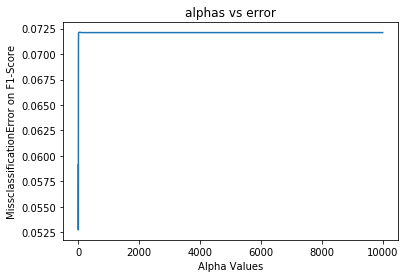

In [6]:
MSE = [1 - x for x in f1score]
alpha_optimal_BoW = alpha_list[MSE.index(min(MSE))]
print('Optimal alpha for NB-BoW = {}'.format(alpha_optimal_BoW))
print("missclassification error for each alpha value: ", np.round(MSE, 3))
#plotting the graph of misclassification error vs alpha

plt.plot(alpha_list, MSE)
plt.title("alphas vs error")
plt.xlabel("Alpha Values")
plt.ylabel("MissclassificationError on F1-Score")
plt.show()

# NB on optimal alpha


CV accuracy for aplha = 1 is 90.415

Accuracy on test set: 90.415

Precision on test set: 0.9138773975178639

Recall on test set: 0.9818748556915262

F1-Score on test set: 0.946656649135988


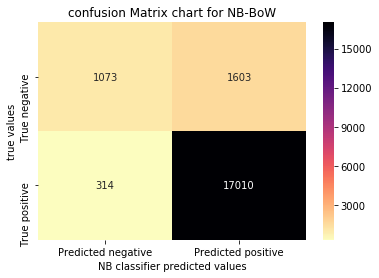

CPU times: user 376 ms, sys: 272 ms, total: 648 ms
Wall time: 234 ms


In [7]:
%%time
optimal_alpha = 1
nbclf = MultinomialNB(alpha=optimal_alpha)
nbclf.fit(X_tr, y_tr)
y_pred = nbclf.predict(X_test)

#performance metrics values:
acc = accuracy_score(y_test, y_pred) * float(100)
print('\nCV accuracy for aplha = {} is {}'.format(optimal_alpha, acc))
print("\nAccuracy on test set: {}".format(accuracy_score(y_test, y_pred)*100))
print("\nPrecision on test set: {}".format(precision_score(y_test, y_pred)))
print("\nRecall on test set: {}".format(recall_score(y_test, y_pred)))
print("\nF1-Score on test set: {}".format(f1_score(y_test, y_pred)))


#plotting confusion matrix:
cf = confusion_matrix(y_test, y_pred)
labels = ['True negative', 'True positive']
df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix chart for NB-BoW")
plt.xlabel("NB classifier predicted values")
plt.ylabel("true values")
plt.show()

## Classification report for NB-BoW

In [8]:
from sklearn.metrics import classification_report
print('Classfication report for NB-BoW algo is:\n\n {}'.format(classification_report(y_test, y_pred)))

Classfication report for NB-BoW algo is:

              precision    recall  f1-score   support

          0       0.77      0.40      0.53      2676
          1       0.91      0.98      0.95     17324

avg / total       0.90      0.90      0.89     20000



 ## Features NB-BoW

In [9]:
#To get all the features name
bow_features = bow.get_feature_names()
print(bow_features[0:3])
#To count feature for each class for optimal trained model, no of sample encountered for each (class, feature) during fitting
feat_count = nbclf.feature_count_
print('optimal feature count shape is {}'.format(feat_count.shape))

['aaa', 'aaaaaaaaagghh', 'aaaaah']
optimal feature count shape is (2, 61055)


In [10]:
# log probability of features given a class(i.e. P(x_i|y)) of optimal NB model
log_prob = nbclf.feature_log_prob_
print(log_prob.shape)
log_prob

(2, 61055)


array([[-12.76150541, -12.76150541, -12.76150541, ..., -12.76150541,
        -12.76150541, -12.76150541],
       [-13.86329927, -13.86329927, -13.45783416, ..., -13.45783416,
        -13.86329927, -13.86329927]])

In [11]:
#creating data frame comprised of feature name and its respective probaility value 
feature_prob_df = pd.DataFrame(log_prob, columns=bow_features,)
feature_prob_df = feature_prob_df.T
feature_prob_df.head(10)

,0,1
aaa,-12.761505,-13.863299
aaaaaaaaagghh,-12.761505,-13.863299
aaaaah,-12.761505,-13.457834
aaaaahhhhhhhhhhhhhhhhth,-12.761505,-13.863299
aaaah,-12.761505,-13.863299
aaah,-12.761505,-13.170152
aachen,-12.068358,-14.556446
aad,-12.761505,-13.863299
aadp,-12.761505,-13.863299
aafco,-12.068358,-13.457834


In [12]:
features = nbclf.coef_

In [13]:
features

array([[-13.86329927, -13.86329927, -13.45783416, ..., -13.45783416,
        -13.86329927, -13.86329927]])

In [15]:
# To show top 20 feature from both class(Feature Importance)
print("Top 25 Negative Features are:-\n",feature_prob_df.iloc[:,0].sort_values(ascending = False)[0:20])
print()
print()
print("Top 25 Positive Features:-\n",feature_prob_df.iloc[:,-1].sort_values(ascending = False)[0:20])

Top 25 Negative Features are:-
 not       -4.004508
tast      -4.416050
like      -4.496370
product   -4.625866
one       -4.911792
flavor    -5.020841
tri       -5.092010
would     -5.098098
good      -5.208743
use       -5.367012
get       -5.386250
buy       -5.386876
tea       -5.396958
order     -5.409706
dont      -5.507328
food      -5.543329
box       -5.593696
coffe     -5.603770
make      -5.604549
much      -5.625022
Name: 0, dtype: float64


Top 25 Positive Features:-
 not       -4.468473
like      -4.490925
tast      -4.538782
tea       -4.676995
good      -4.688379
flavor    -4.723328
great     -4.727144
love      -4.779657
use       -4.828980
one       -4.871675
product   -4.916924
tri       -4.981185
make      -5.049043
get       -5.182373
coffe     -5.373683
eat       -5.394981
best      -5.418892
food      -5.445264
time      -5.479752
realli    -5.487324
Name: 1, dtype: float64


## fearure engineering on BOW:

1. as data is hingly imbalanced(we cud see very lor perf metrics), hence in order to increase perf metrics, we are employing    feature engineering  stratergy so as to increase the minority class label by some percentage
2. stratergy employed is to fresh retrain model with a newly preprocessed column having  concatination of 'text' and 'summary' columns 


In [16]:
#loading cleaned data frame:
df = pd.read_csv('final.csv')

In [17]:
df .columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText_Bow', 'ClenedText_W2V'],
      dtype='object')

In [18]:
#checking for whether any column is haivng Null value?
df.isna().sum()

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   1
Text                      0
CleanedText_Bow           0
ClenedText_W2V            0
dtype: int64

In [19]:
# replacing blank space of one of the cells of 'summary' which is having NaN value:
df['Summary'] = df['Summary'].replace(np.nan, '', regex=True)

In [20]:
df.isna().sum()

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
CleanedText_Bow           0
ClenedText_W2V            0
dtype: int64

In [21]:
#creating new column:
df['new_feat'] = df[['Summary', 'CleanedText_Bow']].apply(lambda x: ' '.join(x),axis=1)

In [22]:
df['new_feat'].head(4)

0    EVERY book is educational witti littl book mak...
1    This whole series is great way to spend time w...
2    Entertainingl Funny! beetlejuic well written m...
3    A modern day fairy tale twist rumplestiskin ca...
Name: new_feat, dtype: object

## data preprocessing on new featured column 

In [23]:
import re

In [24]:
%%time
# removeing HTML TAG
df['new_feat'] = df['new_feat'].apply(lambda x : re.sub('<.*?>','', x)) #No characters to be substitited in place of HTML tag

#removing punctuation marks:
df['new_feat'] = df['new_feat'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]', '', x))

#converting it to lower case:
df['new_feat'] = df['new_feat'].apply(lambda x: x.lower())

CPU times: user 536 ms, sys: 12 ms, total: 548 ms
Wall time: 547 ms


In [25]:
%%time

#supporting libraries for creating stopwords:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


#creating stopwords list:

stop = set(stopwords.words('english')) #set of stopwords
stop = list(stop)
temp = []
list_of_excluded_words = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


for i in range(len(stop)):
    if stop[i] in list_of_excluded_words:
        continue
    else:
        temp.append(stop[i])
stop = set(temp)

CPU times: user 136 ms, sys: 20 ms, total: 156 ms
Wall time: 155 ms


In [26]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer

In [27]:
df['Score'] = df['Score'].apply(lambda x: 'Positive' if int(x) == 1 else 'Negative')

In [28]:
df['Score'].value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [29]:
%%time

#creating list of cleaned words and two seperate lists of pos & neg reviews
i = 0
str1 = ''
final_string = []
all_positive_words = [] # store words from +ve reviews here
all_negative_words = [] # store words from -ve reviews here.
s = ''
for sentence in df['new_feat'].values:
    filtered_sentence = []
    for word in sentence.split():
        if((word not in stop) & (len(word)>2) & (word.isalpha())):    
            s = snow.stem(word).encode('utf8')
            filtered_sentence.append(s)
            if (df['new_feat'].values)[i] == 'Positive': 
                all_positive_words.append(s) #list of all words used to describe positive reviews
            elif(df['new_feat'].values)[i] == 'Negative':
                all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        else:
            continue
 #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("*" * 40)
    
    final_string.append(str1)
    i+=1            

CPU times: user 1min 26s, sys: 24 ms, total: 1min 26s
Wall time: 1min 26s


In [30]:
df['new_feat'] = final_string

In [31]:
df['new_feat'] = df['new_feat'].apply(lambda x: x.decode("utf-8"))

In [32]:
df['new_feat'].head(5)

0    everi book educ witti littl book make son laug...
1    whole seri great way spend time child rememb s...
2    entertainingl funni beetleju well written movi...
3    modern day fairi tale twist rumplestiskin capt...
4    fantast beetleju excel funni movi keaton hilar...
Name: new_feat, dtype: object

In [33]:
df.Score = df.Score.apply(lambda x: 1 if x == 'Positive' else 0)
df.Score.value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [34]:
#selecting top 10000 data points
df = df.iloc[0:100000,]

#train, test cv split
from sklearn.model_selection import train_test_split
TR, XTST, tr,ytst = train_test_split(df['new_feat'].values, df['Score'].values, test_size=0.2,
                                      shuffle=False)
XTR, XCV, ytr,ycv = train_test_split(TR, tr, test_size=0.2, shuffle=False)

In [35]:
#initializing bow vectorizer:
bword = CountVectorizer(ngram_range=(1,1))

In [36]:
#fitting and transforming:
XTR = bow.fit_transform(XTR)
XCV = bow.transform(XCV)
XTST = bow.transform(XTST)

In [37]:
%%time
#Libraries related to performance Metrics:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore')

#CV to find optimal alpha for f1-score performance metric
f1score = []
alpha_list = [10000,5000,1000,500,100,50,10,5,1,0.05,0.01,0.005,0.001,0.0005,0.0001, 0.00001] 
for i in alpha_list:
    nbclf = MultinomialNB(alpha=i)
    nbclf.fit(XTR, ytr)
    y_pred_cv = nbclf.predict(XCV)
    f1score.append(f1_score(y_cv, y_pred_cv))
    #print("F1-Score for aplha = {:<2d} ,on cv set is :{:<.3f}".format(i, f1_score(y_cv, y_pred_cv)))
    

CPU times: user 632 ms, sys: 0 ns, total: 632 ms
Wall time: 631 ms


Optimal alpha for NB-BoW = 1
missclassification error for each alpha value:  [0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.069 0.046 0.047 0.048 0.049
 0.05  0.051 0.052 0.054]


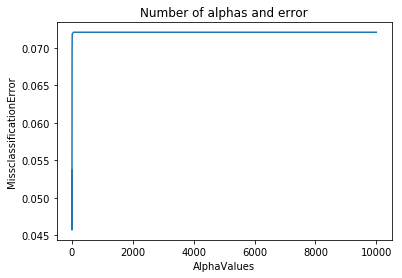

In [38]:
MSE = [1 - x for x in f1score]
alpha_optimal_BoW = alpha_list[MSE.index(min(MSE))]
print('Optimal alpha for NB-BoW = {}'.format(alpha_optimal_BoW))
print("missclassification error for each alpha value: ", np.round(MSE, 3))
#plotting the graph of misclassification error vs alpha

plt.plot(alpha_list, MSE)
plt.title("Number of alphas and error")
plt.xlabel("AlphaValues")
plt.ylabel("MissclassificationError")
plt.show()


CV accuracy for aplha = 0.05 is 91.455

Accuracy on test set: 91.455

Precision on test set: 0.9536870242315068

Recall on test set: 0.9473562687601016

F1-Score on test set: 0.9505111053195494


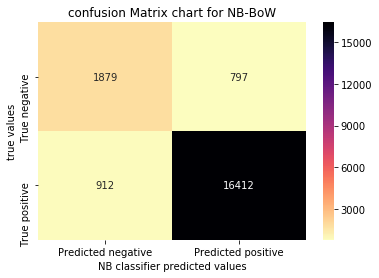

CPU times: user 436 ms, sys: 296 ms, total: 732 ms
Wall time: 278 ms


In [39]:
%%time
optimal_alpha = 0.05
nbclf = MultinomialNB(alpha=optimal_alpha)
nbclf.fit(XTR, ytr)
y_pred = nbclf.predict(XTST)

#performance metrics values:
acc = accuracy_score(ytst, y_pred) * float(100)
print('\nCV accuracy for aplha = {} is {}'.format(optimal_alpha, acc))
print("\nAccuracy on test set: {}".format(accuracy_score(ytst, y_pred)*100))
print("\nPrecision on test set: {}".format(precision_score(ytst, y_pred)))
print("\nRecall on test set: {}".format(recall_score(ytst, y_pred)))
print("\nF1-Score on test set: {}".format(f1_score(ytst, y_pred)))


#plotting confusion matrix:
cf = confusion_matrix(ytst, y_pred)
labels = ['True negative', 'True positive']
df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix chart for NB-BoW")
plt.xlabel("NB classifier predicted values")
plt.ylabel("true values")
plt.show()

In [40]:
from sklearn.metrics import classification_report
print('Classfication report for NB-BoW algo is:\n\n {}'.format(classification_report(y_test, y_pred)))

Classfication report for NB-BoW algo is:

              precision    recall  f1-score   support

          0       0.67      0.70      0.69      2676
          1       0.95      0.95      0.95     17324

avg / total       0.92      0.91      0.92     20000



In [42]:
## pickeling the featured dataframe onto disk:
file1 = open('df_featured_column.pickle', 'wb')
# dump information to that file
pickle.dump(df, file1)
# closing the file
file1.close()

## we could see after feature engineering we improved the model performace by 15% !!!!!

## TF-IDF

In [43]:
import pickle
# open file objects wrt datapoints X_tr, X_cv X_test
file1 = open('X_tr.pickle', '+rb')
file2 = open('X_cv.pickle', '+rb')
file3 = open('X_test.pickle', '+rb')

# load information to that file
X_tr = pickle.load(file1)
X_cv = pickle.load(file2)
X_test =pickle.load(file3)

# close the file
file1.close()
file2.close()
file3.close()


# open files object wrt class labels for y_tr, y_cv and y_test
file1 = open('y_tr.pickle', '+rb')
file2 = open('y_cv.pickle', '+rb')
file3 = open('y_test.pickle', '+rb')

# load information to that file
y_tr = pickle.load(file1)
y_cv = pickle.load(file2)
y_test =pickle.load(file3)

# close the file
file1.close()
file2.close()
file3.close()

In [44]:
#tfidf vectorizor:
from sklearn.feature_extraction.text import TfidfVectorizer

#fitting and transforming:
tfidf = CountVectorizer(ngram_range=(1,1))
X_tr = tfidf.fit_transform(X_tr)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)

## CV to find optimal alpha

In [45]:
%%time
#Libraries related to performance Metrics:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore')

#CV to find optimal alpha for f1-score performance metric
f1score = []
alpha_list = [10000,5000,1000,500,100,50,10,5,1,0.05,0.01,0.005,0.001,0.0005,0.0001, 0.00001] 
for i in alpha_list:
    nbclf = MultinomialNB(alpha=i)
    nbclf.fit(X_tr, y_tr)
    y_pred_cv = nbclf.predict(X_cv)
    f1score.append(f1_score(y_cv, y_pred_cv))
    #print("F1-Score for aplha = {:<2d} ,on cv set is :{:<.3f}".format(i, f1_score(y_cv, y_pred_cv)))
    

CPU times: user 608 ms, sys: 4 ms, total: 612 ms
Wall time: 608 ms


## MisclassificationError on F1-Score

Optimal alpha for NB-TFIDF = 1
missclassification error for each alpha value:  [0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.071 0.053 0.053 0.055 0.056
 0.057 0.057 0.058 0.059]


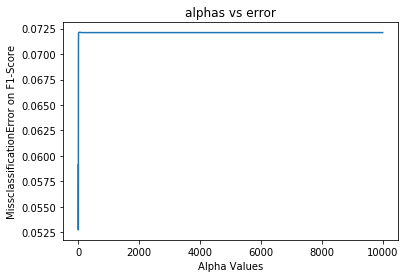

In [46]:
MSE = [1 - x for x in f1score]
alpha_optimal_tfidf = alpha_list[MSE.index(min(MSE))]
print('Optimal alpha for NB-TFIDF = {}'.format(alpha_optimal_tfidf))
print("missclassification error for each alpha value: ", np.round(MSE, 3))
#plotting the graph of misclassification error vs alpha

plt.plot(alpha_list, MSE)
plt.title("alphas vs error")
plt.xlabel("Alpha Values")
plt.ylabel("MissclassificationError on F1-Score")
plt.show()

## training NB-tfidf model on optimal alpha


CV accuracy for aplha = 1 is 90.415

Accuracy on test set: 90.415

Precision on test set: 0.9138773975178639

Recall on test set: 0.9818748556915262

F1-Score on test set: 0.946656649135988


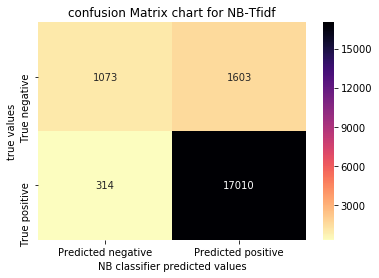

CPU times: user 304 ms, sys: 220 ms, total: 524 ms
Wall time: 235 ms


In [47]:
%%time
optimal_alpha = 1
nbclf = MultinomialNB(alpha=optimal_alpha)
nbclf.fit(X_tr, y_tr)
y_pred = nbclf.predict(X_test)

#performance metrics values:
acc = accuracy_score(y_test, y_pred) * float(100)
print('\nCV accuracy for aplha = {} is {}'.format(optimal_alpha, acc))
print("\nAccuracy on test set: {}".format(accuracy_score(y_test, y_pred)*100))
print("\nPrecision on test set: {}".format(precision_score(y_test, y_pred)))
print("\nRecall on test set: {}".format(recall_score(y_test, y_pred)))
print("\nF1-Score on test set: {}".format(f1_score(y_test, y_pred)))


#plotting confusion matrix:
cf = confusion_matrix(y_test, y_pred)
labels = ['True negative', 'True positive']
df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix chart for NB-Tfidf")
plt.xlabel("NB classifier predicted values")
plt.ylabel("true values")
plt.show()

In [48]:
from sklearn.metrics import classification_report
print('Classfication report for NB-Tfidf algo is:\n\n {}'.format(classification_report(y_test, y_pred)))

Classfication report for NB-Tfidf algo is:

              precision    recall  f1-score   support

          0       0.77      0.40      0.53      2676
          1       0.91      0.98      0.95     17324

avg / total       0.90      0.90      0.89     20000



## as we could see above f1 score was low on minority class,
1.  we would employ feature engineering stratergy as an attempt to increase the minority class prediction by classifier             afterwards.

## Features extraction on NB-Tfidf

In [50]:
#To get all the features name
tfidf_features = tfidf.get_feature_names()
print(tfidf_features[0:3])
#To count feature for each class for optimal trained model, no of sample encountered for each (class, feature) during fitting
feat_count = nbclf.feature_count_
print('optimal feature count shape is {}'.format(feat_count.shape))

['aaa', 'aaaaaaaaagghh', 'aaaaah']
optimal feature count shape is (2, 61055)


In [51]:
# log probability of features given a class(i.e. P(x_i|y)) of optimal NB model
log_prob = nbclf.feature_log_prob_
print(log_prob.shape)
log_prob

(2, 61055)


array([[-12.76150541, -12.76150541, -12.76150541, ..., -12.76150541,
        -12.76150541, -12.76150541],
       [-13.86329927, -13.86329927, -13.45783416, ..., -13.45783416,
        -13.86329927, -13.86329927]])

In [52]:
#creating data frame comprised of feature name and its respective probaility value 
feature_prob_df = pd.DataFrame(log_prob, columns=tfidf_features,)
feature_prob_df = feature_prob_df.T
feature_prob_df.head(10)

,0,1
aaa,-12.761505,-13.863299
aaaaaaaaagghh,-12.761505,-13.863299
aaaaah,-12.761505,-13.457834
aaaaahhhhhhhhhhhhhhhhth,-12.761505,-13.863299
aaaah,-12.761505,-13.863299
aaah,-12.761505,-13.170152
aachen,-12.068358,-14.556446
aad,-12.761505,-13.863299
aadp,-12.761505,-13.863299
aafco,-12.068358,-13.457834


In [53]:
tfidf_features = nbclf.coef_

## NBTfidf top 25 feature from both class(Feature Importance)

In [54]:
# To show top 25 feature from both class(Feature Importance)
print("Top 25 Negative Features are:-\n",feature_prob_df.iloc[:,0].sort_values(ascending = False)[0:20])
print()
print()
print("Top 25 Positive Features:-\n",feature_prob_df.iloc[:,-1].sort_values(ascending = False)[0:20])

Top 25 Negative Features are:-
 not       -4.004508
tast      -4.416050
like      -4.496370
product   -4.625866
one       -4.911792
flavor    -5.020841
tri       -5.092010
would     -5.098098
good      -5.208743
use       -5.367012
get       -5.386250
buy       -5.386876
tea       -5.396958
order     -5.409706
dont      -5.507328
food      -5.543329
box       -5.593696
coffe     -5.603770
make      -5.604549
much      -5.625022
Name: 0, dtype: float64


Top 25 Positive Features:-
 not       -4.468473
like      -4.490925
tast      -4.538782
tea       -4.676995
good      -4.688379
flavor    -4.723328
great     -4.727144
love      -4.779657
use       -4.828980
one       -4.871675
product   -4.916924
tri       -4.981185
make      -5.049043
get       -5.182373
coffe     -5.373683
eat       -5.394981
best      -5.418892
food      -5.445264
time      -5.479752
realli    -5.487324
Name: 1, dtype: float64


## Feature engineering : an attempt to imporove minority class prediction on NBTfidf

In [55]:
#pickeling the preprocessed data frame
file = open('df_featured_column.pickle', '+rb')
df = pickle.load(file)
file.close()

In [57]:
df['new_feat'].head(10)

0    everi book educ witti littl book make son laug...
1    whole seri great way spend time child rememb s...
2    entertainingl funni beetleju well written movi...
3    modern day fairi tale twist rumplestiskin capt...
4    fantast beetleju excel funni movi keaton hilar...
5    great one movi movi collect fill comedi action...
6    clamshel edit edit version alway enjoy movi fu...
7    sure death fli bought apart infest fruit fli h...
8    bettlejuicebettlejuicebettlejuic happen say na...
9    research beatlejuic video french version get c...
Name: new_feat, dtype: object

In [58]:
#train, test cv split
from sklearn.model_selection import train_test_split
TR, XTST, tr,ytst = train_test_split(df['new_feat'].values, df['Score'].values, test_size=0.2,
                                      shuffle=False)
XTR, XCV, ytr,ycv = train_test_split(TR, tr, test_size=0.2, shuffle=False)

In [59]:
#initializing tfidf vectorizer:
tfid = CountVectorizer(ngram_range=(1,1))

In [60]:
#fitting and transforming:
XTR = tfid.fit_transform(XTR)
XCV = tfid.transform(XCV)
XTST = tfid.transform(XTST)

## CV to find optimal alpha

In [61]:
%%time
#Libraries related to performance Metrics:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
warnings.filterwarnings('ignore')

#CV to find optimal alpha for f1-score performance metric
f1score = []
alpha_list = [10000,5000,1000,500,100,50,10,5,1,0.05,0.01,0.005,0.001,0.0005,0.0001, 0.00001] 
for i in alpha_list:
    nbclf = MultinomialNB(alpha=i)
    nbclf.fit(XTR, ytr)
    y_pred_cv = nbclf.predict(XCV)
    f1score.append(f1_score(y_cv, y_pred_cv))
    #print("F1-Score for aplha = {:<2d} ,on cv set is :{:<.3f}".format(i, f1_score(y_cv, y_pred_cv)))
    

CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 585 ms


## misclassfication error(f1-score) vc alpha

Optimal alpha for NB-tfid = 1
missclassification error for each alpha value:  [0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.069 0.046 0.047 0.048 0.049
 0.05  0.051 0.052 0.054]


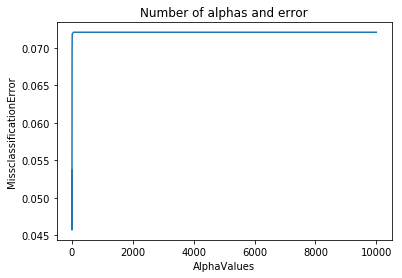

In [62]:
MSE = [1 - x for x in f1score]
alpha_optimal_tfid = alpha_list[MSE.index(min(MSE))]
print('Optimal alpha for NB-tfid = {}'.format(alpha_optimal_tfid))
print("missclassification error for each alpha value: ", np.round(MSE, 3))
#plotting the graph of misclassification error vs alpha

plt.plot(alpha_list, MSE)
plt.title("Number of alphas and error")
plt.xlabel("AlphaValues")
plt.ylabel("MissclassificationError")
plt.show()

##  NB-IDF featured model on optimal aplha


CV accuracy for aplha = 1 is 91.675

Accuracy on test set: 91.675

Precision on test set: 0.9282861987856245

Recall on test set: 0.9795659201108289

F1-Score on test set: 0.953236904929083


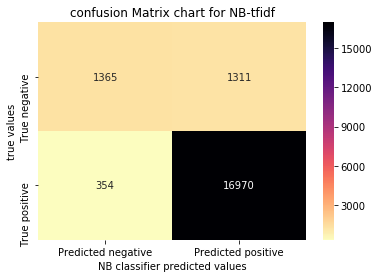

CPU times: user 352 ms, sys: 220 ms, total: 572 ms
Wall time: 255 ms


In [63]:
%%time
optimal_alpha = 1
nbclf = MultinomialNB(alpha=optimal_alpha)
nbclf.fit(XTR, ytr)
y_pred = nbclf.predict(XTST)

#performance metrics values:
acc = accuracy_score(ytst, y_pred) * float(100)
print('\nCV accuracy for aplha = {} is {}'.format(optimal_alpha, acc))
print("\nAccuracy on test set: {}".format(accuracy_score(ytst, y_pred)*100))
print("\nPrecision on test set: {}".format(precision_score(ytst, y_pred)))
print("\nRecall on test set: {}".format(recall_score(ytst, y_pred)))
print("\nF1-Score on test set: {}".format(f1_score(ytst, y_pred)))


#plotting confusion matrix:
cf = confusion_matrix(ytst, y_pred)
labels = ['True negative', 'True positive']
df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix chart for NB-tfidf")
plt.xlabel("NB classifier predicted values")
plt.ylabel("true values")
plt.show()

In [64]:
from sklearn.metrics import classification_report
print('Classfication report for NB-BoW algo is:\n\n {}'.format(classification_report(y_test, y_pred)))

Classfication report for NB-BoW algo is:

              precision    recall  f1-score   support

          0       0.79      0.51      0.62      2676
          1       0.93      0.98      0.95     17324

avg / total       0.91      0.92      0.91     20000



## aftre applying feature engineeering,we could see f1 score on minority class prediction is improved by 15 % !!

In [67]:
from prettytable import PrettyTable

In [70]:
x = PrettyTable()
x.field_names = ['Algorithm Name', 'Optimal-alpha', 'F1-Score-majority class', "F1-Score-minority class"]

x.add_row(['1. NB-Bow',0.05, 0.98, 0.53])
x.add_row(['2. NB-Bow(with-Featured engineering)', 0.05, 0.95, 0.69])
x.add_row(['3. NB-TFidf',1, 0.98, 0.40])
x.add_row(['4. NB-tfidf(with-featured engineering)', 1, 0.95,0.51])
print(x)

+----------------------------------------+---------------+-------------------------+-------------------------+
|             Algorithm Name             | Optimal-alpha | F1-Score-majority class | F1-Score-minority class |
+----------------------------------------+---------------+-------------------------+-------------------------+
|               1. NB-Bow                |      0.05     |           0.98          |           0.53          |
|  2. NB-Bow(with-Featured engineering)  |      0.05     |           0.95          |           0.69          |
|              3. NB-TFidf               |       1       |           0.98          |           0.4           |
| 4. NB-tfidf(with-featured engineering) |       1       |           0.95          |           0.51          |
+----------------------------------------+---------------+-------------------------+-------------------------+
